In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

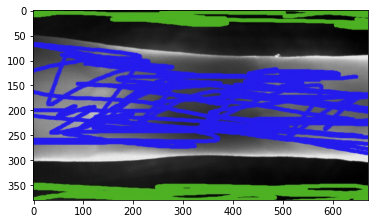

In [2]:
# Load our Image
img = cv2.imread('images/UTFVP/0003_6_4_120524-161445.png')       # very good   
img_w_handmade_markers = cv2.imread('images/UTFVP/0003_6_4_120524-161445_markers.jpg')                    # bad
#img = cv2.imread('images/UTFVP/0007_6_3_120523-110018.png')       # very good

#img = cv2.imread('images/UTFVP/0001_3_4_120523-100949 (1).png')   # good/bad   
#img = cv2.imread('images/UTFVP/0046_3_4_120523-160627.png')       # good/bad   
#img = cv2.imread('images/UTFVP/0053_1_1_120511-103029.png')       # good/bad   
#img = cv2.imread('images/FV-USM/01 (6).jpg')                      # good/bad   

#img = cv2.imread('images/UTFVP/0001_4_2_120509-135641 (1).png')   # bad 
#img = cv2.imread('images/UTFVP/0001_4_3_120523-100811 (1).png')   # bad    
#img = cv2.imread('images/FV-USM/30_4 (1).jpg')                    # bad    
#img_w_handmade_markers = cv2.imread('images/FV-USM/047_1 (4)_markers.jpg')                    # bad
#img = cv2.imread('images/FV-USM/047_1 (4).jpg')                   # bad

#img_w_handmade_markers = cv2.cvtColor(img_w_handmade_markers, cv2.COLOR_BGR2RGB)
plt.imshow(img_w_handmade_markers)

# Convert the image to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Apply a thresholding of the image in order to calculate Markers later
# PARAMETERS: Otsu is not as good as Triangle Thresholding! # cv2.THRESH_OTSU / 
# THRES BINARY INV makes a binary image, inverted (foreground and background)
ret, binary_thresh_img = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_TRIANGLE)

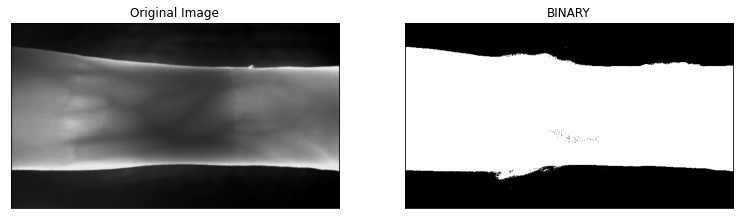

In [3]:
# Display the original Image and the thresholded binary Image
titles = ['Original Image','BINARY']
images = [img, binary_thresh_img]

# Display the original Image and the thresholded binary Image
plt.figure(figsize=(20,10))
for i in range(2):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

In [4]:
# Remove small wihte noise by using a morphological opening.
kernel = np.ones((3,3),np.uint8)
# PARAMETER - opening is the wrong one, closing is Dilation followed by erosion
# eliminates the remaining black pixels inside the foreground
#opening = cv2.morphologyEx(binary_thresh_img,cv2.MORPH_OPEN,kernel, iterations = 20)
closing = cv2.morphologyEx(binary_thresh_img,cv2.MORPH_CLOSE,kernel, iterations = 10)

# Dilate the foreground some iterations to let the foreground grow and get the sure background
# PARAMETER - ITERATIONS IS A PARAMETER TO CONSIDER
sure_bg = cv2.dilate(closing,kernel,iterations=1)

#sure_bg = closing
# Finding sure foreground area
# Calculate the distance of the foreground pixels to the background (closest zero pixel)
# The morphologically opened image is used
# L2 Norm is used for distance
# Kernel is 3x3
dist_transform = cv2.distanceTransform(closing,cv2.DIST_L2,3)

# A thresholding, setting every value to WHITE (sure foreground)
# PARAMETER: The thresholding distance value! 0.2 is good, 0.1 is not so good anymore
ret, sure_fg = cv2.threshold(dist_transform,0.2*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

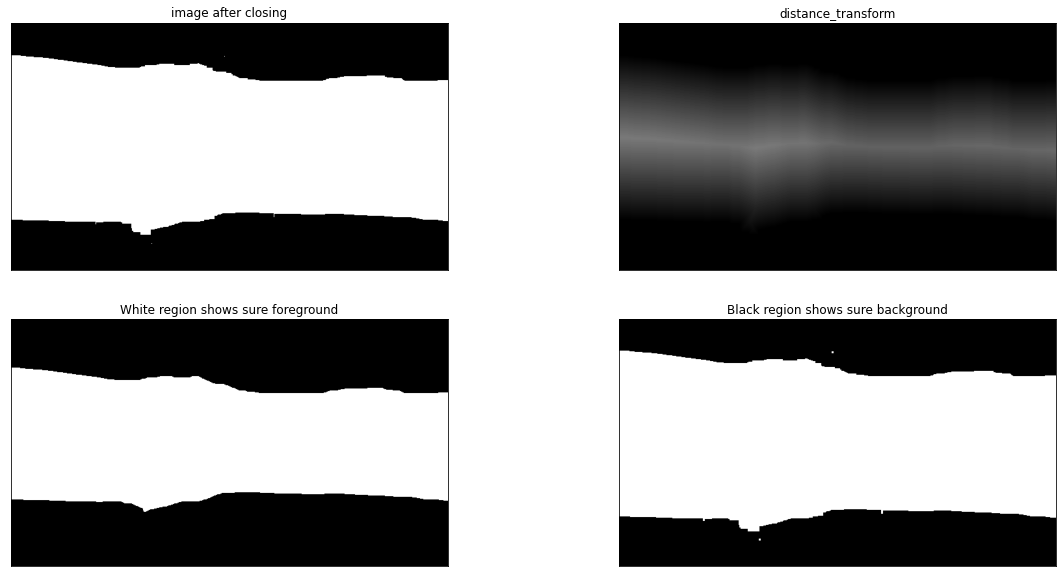

In [5]:
# Display the distance trasnformed image, the sure fore and background
titles = ['image after closing', 'distance_transform', 'White region shows sure foreground', 'Black region shows sure background']
images = [closing, dist_transform, sure_fg, sure_bg]

# Display the distance trasnformed image, the sure fore and background
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

Text(0.5, 1.0, 'Handmade Background Markers after Closing - Binary')

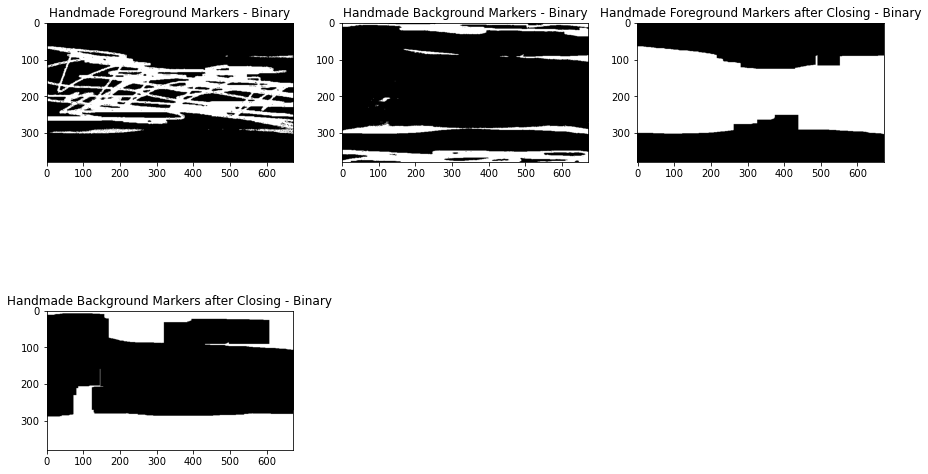

In [6]:
## THRESHOLDED AND MORPHOLOGICALLY MODDED MARKERS
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0




## HANDDRAWN BACKGROUND MARKERS

# Handmade markers of the two regions
# Take all y and all x, but take only green color - marker color was green
handmade_background_green = img_w_handmade_markers[:,:,1]

# A thresholding, setting every value to WHITE (sure foreground)
# PARAMETER: The thresholding distance value! 0.2 is good, 0.1 is not so good anymore
ret, handmade_bg_binary = cv2.threshold(handmade_background_green, 170,255,cv2.THRESH_BINARY)

# Remove small wihte noise by using a morphological opening.
kernel = np.ones((3,3),np.uint8)
# PARAMETER - opening is the wrong one, closing is Dilation followed by erosion
# eliminates the remaining black pixels inside the foreground
#opening = cv2.morphologyEx(binary_thresh_img,cv2.MORPH_OPEN,kernel, iterations = 20)
handmade_bg_binary_closed = cv2.morphologyEx(handmade_bg_binary,cv2.MORPH_CLOSE,kernel, iterations = 30)

# Marker labelling
ret, handmade_markers_bg = cv2.connectedComponents(handmade_bg_binary_closed)

# Add one to all labels so that sure background is not 0, but 1
handmade_markers_bg = handmade_markers_bg+1

# Now, mark the region of unknown with zero
handmade_markers_bg[unknown==255] = 0





## HANDDRAWN FOREGROUND MARKERS

# Take all y and all x, but take only green red - marker color was red
handmade_foreground_red = img_w_handmade_markers[:,:,2]

# A thresholding, setting every value to WHITE (sure foreground)
# PARAMETER: The thresholding distance value! 0.2 is good, 0.1 is not so good anymore
ret, handmade_fg_binary = cv2.threshold(handmade_foreground_red, 225,255,cv2.THRESH_BINARY)

# Remove small wihte noise by using a morphological opening.
kernel = np.ones((3,3),np.uint8)
# PARAMETER - opening is the wrong one, closing is Dilation followed by erosion
# eliminates the remaining black pixels inside the foreground
#opening = cv2.morphologyEx(binary_thresh_img,cv2.MORPH_OPEN,kernel, iterations = 20)
handmade_fg_binary_closed = cv2.morphologyEx(handmade_fg_binary,cv2.MORPH_CLOSE,kernel, iterations = 30)

# Marker labelling
ret, handmade_markers_fg = cv2.connectedComponents(handmade_fg_binary_closed)

# Add one to all labels so that sure background is not 0, but 1
handmade_markers_fg = handmade_markers_fg+1

# Now, mark the region of unknown with zero
handmade_markers_fg[unknown==255] = 0


plt.figure(figsize=(15,15))
plt.subplot(3,3,1),plt.imshow(handmade_fg_binary, 'gray')
plt.title('Handmade Foreground Markers - Binary')
plt.subplot(3,3,2),plt.imshow(handmade_bg_binary, 'gray')
plt.title('Handmade Background Markers - Binary')
plt.subplot(3,3,3),plt.imshow(handmade_fg_binary_closed, 'gray')
plt.title('Handmade Foreground Markers after Closing - Binary')
plt.subplot(3,3,4),plt.imshow(handmade_bg_binary_closed, 'gray')
plt.title('Handmade Background Markers after Closing - Binary')

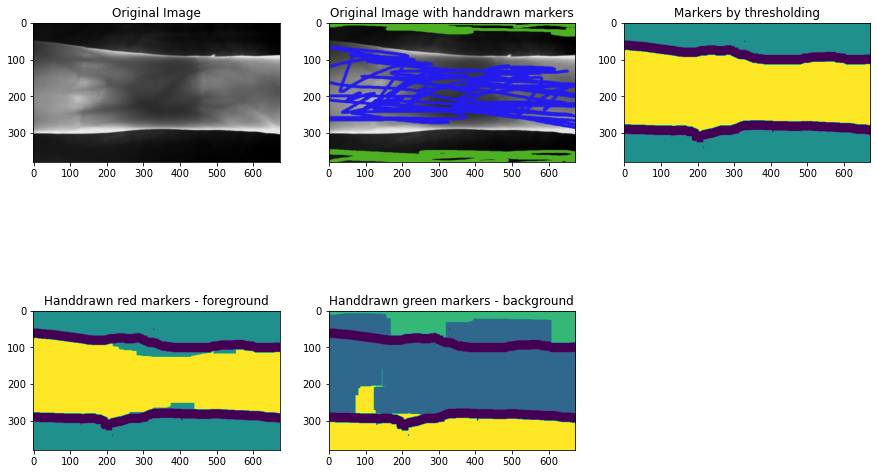

In [7]:
plt.figure(figsize=(15,15))
plt.subplot(3,3,1),plt.imshow(img, vmin=0)
plt.title('Original Image')
plt.subplot(3,3,2),plt.imshow(img_w_handmade_markers)
plt.title('Original Image with handdrawn markers')
plt.subplot(3,3,3),plt.imshow(markers, vmin=0,vmax=markers.max())
plt.title('Markers by thresholding')
plt.subplot(3,3,4),plt.imshow(handmade_markers_fg, vmin=0,vmax=handmade_markers_fg.max())
plt.title('Handdrawn red markers - foreground')
plt.subplot(3,3,5),plt.imshow(handmade_markers_bg, vmin=0,vmax=handmade_markers_bg.max())
plt.title('Handdrawn green markers - background')

plt.show()

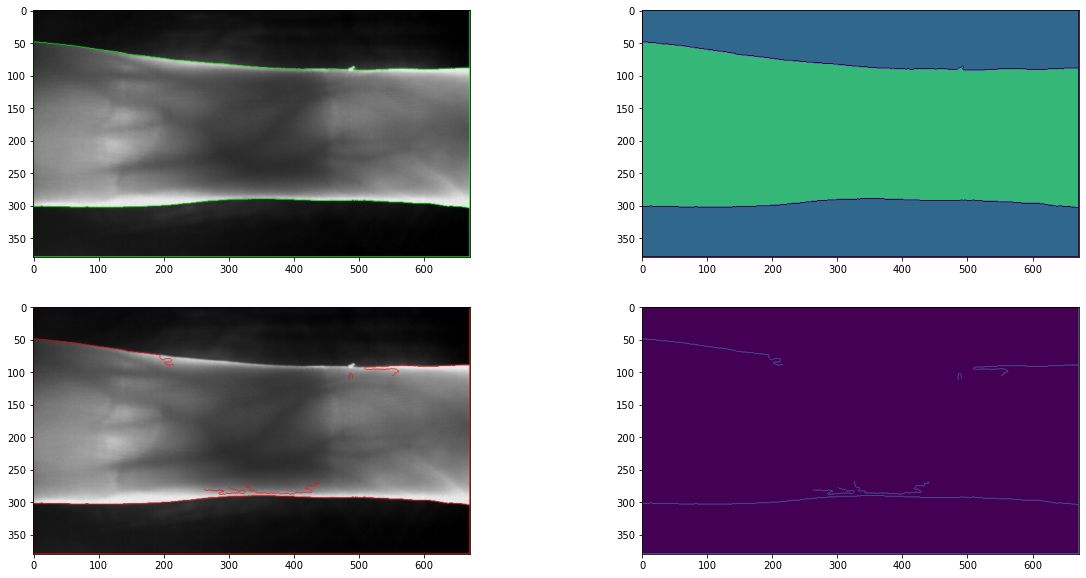

In [8]:
# Display the original Image and the thresholded binary Image
plt.figure(figsize=(20,10))

img2 = img.copy()
    
# Use the watershed algorithm with our custom markers
markers = cv2.watershed(img,markers)
handmade_markers = cv2.watershed(img2,handmade_markers_fg)

# red color for the markers
img[markers == -1] = [0,255,0]
img2[handmade_markers == -1] = [255,0,0]

gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)

lines = cv2.HoughLines(edges,1,np.pi/180,200)

for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

cv2.line(img2,(x1,y1),(x2,y2),(0,0,255),2)
    
plt.subplot(2,2,1),plt.imshow(img,'gray',vmin=0,vmax=255)
plt.subplot(2,2,2),plt.imshow(markers, vmin=0,vmax=handmade_markers_bg.max())
plt.subplot(2,2,3),plt.imshow(img2,vmin=0,vmax=255)
plt.subplot(2,2,4),plt.imshow((handmade_markers == -1), vmin=0,vmax=handmade_markers_bg.max())

i+=1

plt.show()

Text(0.5, 1.0, 'With lines')

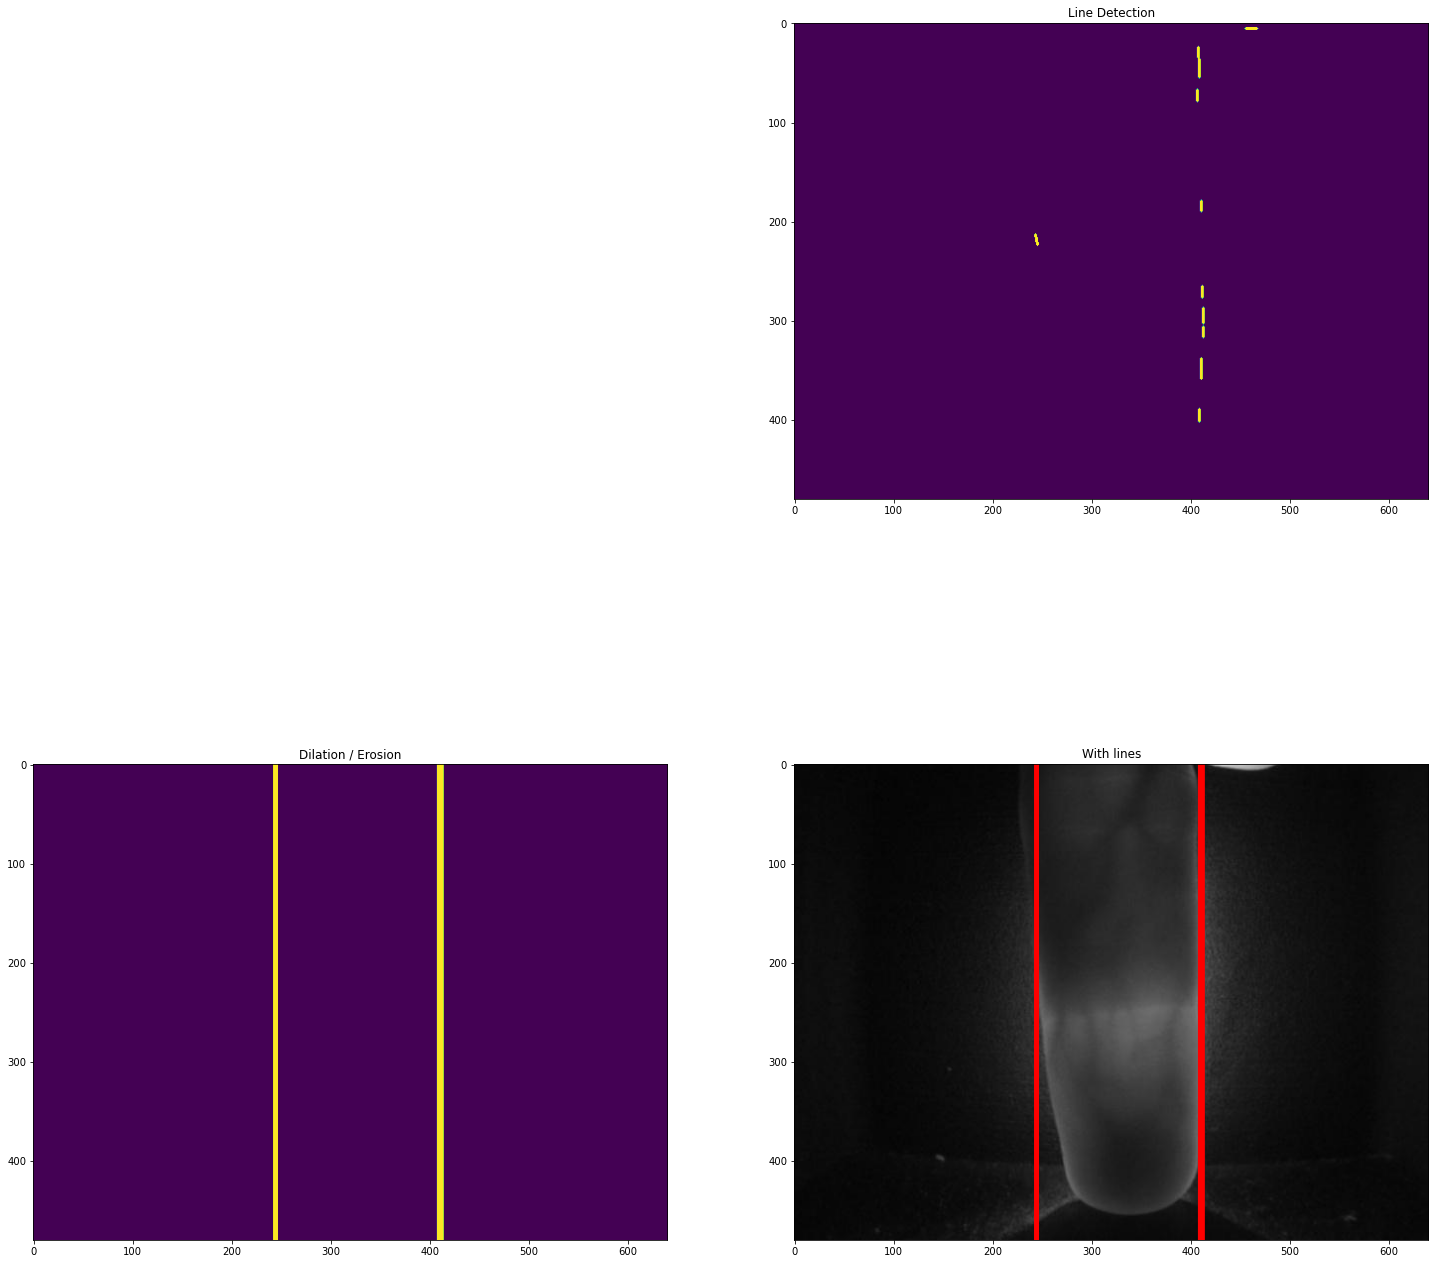

In [18]:
vertical = True

#img = cv2.imread('images/UTFVP/0001_4_3_120523-100811 (1).png')# vertical = False
img = cv2.imread('images/FV-USM/047_1 (4).jpg')# vertical = True
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)

#plt.imshow(edges)

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)

minLineLength = 100
maxLineGap = 10

#marker_image = np.zeros((img.shape[0],img.shape[1],3), np.uint8) 
#marker_image = cv2.cvtColor(marker_image,cv2.COLOR_BGR2GRAY)
#marker_image[markers == -1] = [255]


lines = cv2.HoughLinesP(edges,1,np.pi/180,5,minLineLength,maxLineGap)
line_image = np.zeros((img.shape[0],img.shape[1],3), np.uint8) 
line_image = cv2.cvtColor(line_image,cv2.COLOR_BGR2GRAY)

for line in lines:    
    for x1,y1,x2,y2 in line:
         cv2.line(line_image,(x1,y1),(x2,y2),(255,255,255),2)

if vertical:
    # horizontal kernel
    kernel = np.ones((20,1), np.uint8)
else:
    # vertical kernel
    kernel = np.ones((1,20), np.uint8)

d_im = cv2.dilate(line_image, kernel, iterations=35)
line_image2 = cv2.erode(d_im, kernel, iterations=80) 
img[line_image2 == 255] = [255,0,0]

#plt.imshow(img)
plt.figure(figsize=(25,25))
#plt.imshow(line_image)
#plt.subplot(2,2,1),plt.imshow(marker_image)
#plt.title('Watershed Segmentation')
plt.subplot(2,2,2),plt.imshow(line_image)
plt.title('Line Detection')
plt.subplot(2,2,3),plt.imshow(line_image2)
plt.title('Dilation / Erosion')
plt.subplot(2,2,4),plt.imshow(img)
plt.title('With lines')
